# Calibration

The two main qualities we'd like to have in a robotics system are **accuracy** and **repeatability**.

Accuracy is the capability of a robot of having scores near to the groundthruths.
Repeatability is the capability of a robot of having near scores.

In order to improve:
- accuracy we need calibration
- repeatability we need better components

Calibration process needs a **linearization of direct kinematics**.

Assuming all revolute joints, the nominal parameters are: $α, a$ and $d$ (all vectors of dimensions nx1).
Thus, the direct kinematics in its nominal conditions is $r_{nom} = f(α, a, d, θ)$ where θ are typically measured by encoders.
Data can be affected by some errors and even small errors are amplified at the e-e level.
The groundthruth is called here $r$, and it is obtained by some external measurements.
The error is $Δr = r-r_{nom}$.
This difference can be approximated through Taylor series expansion:
$Δr = {∂f \over ∂α} Δα + {∂f \over ∂a} Δa + {∂f \over ∂d} Δd + {∂f \over ∂θ} Δθ$.

We call:
- Δϕ the vector of displacements $Δϕ = [Δα \space Δa \space Δd \space Δθ]^T$ of dimension 4nx1. This is the vector of unknowns that we will use to correct the nominal parameters.
- Φ the matrix of partial jacobians evaluated at nominal parameters $Φ = [{∂f \over ∂α} \space {∂f \over ∂a} \space {∂f \over ∂d} \space {∂f \over ∂θ}]$ of dimensions 6x4n.

Then we get $Δr = ΦΔϕ$ which is a linear equation of 6 rows.

Usually we have $l$ experiments (with $l>>n$), so we stack all those $l*6$ rows and obtain:

$Δr̄ = Φ̄  Δϕ$

then, by pseudoinverting, we get:

$Δϕ = Φ^\# Δr̄$

The adjustment is added:

$ϕ'= ϕ_{nom} + Δϕ$

This process can be iterated until some convergence is reached.

# Redundancy

It is a condition for the robot when the number of DoF $N$ is greater than the number of task variables $M$. For instance a robot is redundant wrt a certain task.

We can exploit the "extra" degrees of freedom of a robot for several issues (e.g. avoid collision with obstacles, stay within admissible joint ranges, ...).

When $N > M$, the inverse kinematics problem (find q(t) that realizes the task r(t) at any t) becomes an issue since there exists infinite solutions.  
In general this problem is faced at a differential level:

$ṙ = J(q) q̇$

To solve it we can follow local or global methods. Local methods are those that given $ṙ(t), q(t), t=kT_s$ we find $q̇(kT_s)$ online through the minimization of an objective function.Global methods are used offline (and they are not of interest in this course).

In local methods, we can distinguish between 3 main approaches:

1. **Jacobian-based methods**: among infinite solutions, one is chosen (typically the one minimizing a norm)
2. **Null-space methods**: a term is added to the previous solution so as not to affect execution of the task trajectory (belonging to the null space of J)
3. **Task augmentation methods**: redundancy is reduced/eliminated by adding auxiliary tasks







## Jacobian-based methods

We seek for a solution in the form $q̇ = K(q) ṙ$, where K is a generalized inverse of J.

There may be many types of generalized inverse:
- pseudoinverse $J^\# = J^T(JJ^T)^{-1}$ if J is full rank, else use SVD
- weighted pseudoinverse: $J^\#_W = W^{-1}J^T(JW^{-1}J^T)^{-1}$. Intuitively large weight $w_i$ means small $q_i$
- damped least square: $J_{DLS} =  J^T(JJ^T+μ^2 I_M)^{-1}$, used when we are in a singularity

Remember those properties of the pseudoinverse:
- $JJ^\#J = J$
- $J^\#JJ^\# = J^\#$
- $(JJ^\#)^T = JJ^\#$
- $(J^\#J)^T = J^\#J$

The pseudoinverse is the only that minimizes the norm $||q̇||^2$ among all joint velocities that minimize the task error.

## Null-Space Methods

The general solution here is in the form:

$q̇ = K_1 ṙ + (I-K_2J)q_{0}̇$

where the first term takes a particular solution in $R(J^T)$ (typical by using $K_1 = J^\#$) and the second term represents all the solutions of the associated homogeneous equation $Jq̇ = 0$, so the self-motion. Again $K_2$ is $J^\#$ typically.
This second term is called "projector" and it is:
- symmetric,
- idempotent $(I-J^\#J)^2 = (I-J^\#J)$
- $J^\#ṙ$ is orthogonal to $(I-J^\#J)q_0̇$
- has dimension $NxN$, but only rank $N-M$

$q_0̇ $ is a privileged joint velocity, which can be computed by using:
- Projected Gradient
- Reduced Gradient


### Projected Gradient

The choice $q̇_{0}$ is $q̇_{0} = ∇_q H(q)$, where H is a differentiable objective function varying based on the goal to achieve:

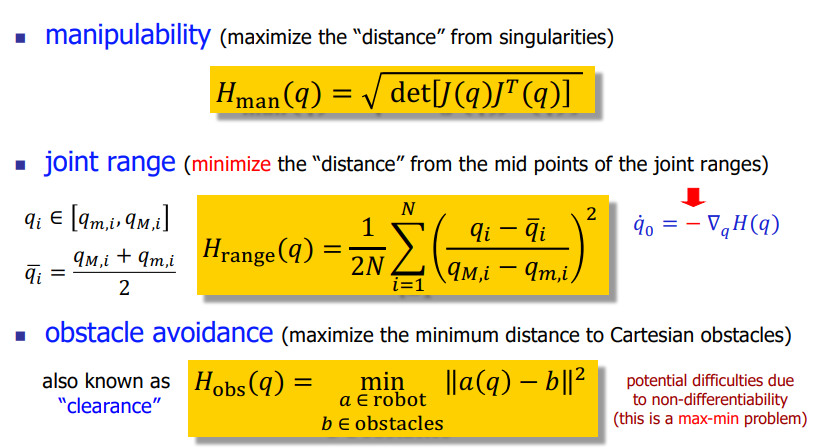


### Reduced Gradient

If $rank(J(q)) = M$ then there exists a decomposition in the joint space: $q = (q_a, q_b)$, where $q_a$ has dimensions M. Thus, $f(q_a, q_b) = r$ can be rewritten as $f(g(r, q_b), q_b)$ from the implicit function theorem.
For instance, even $H(q) = H(q_a, q_b)$ can be rewritten as $H(g(r, q_b), q_b)$.
When r is at a current value $H(g(r, q_b), q_b) = H'(q_b)$.

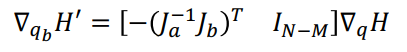

### PG vs RG

RG is analytically simpler and numerically faster than PG, but requires the search of a non-singular minor of J.

If r is a constant and N-M = 1, the solution for $q̇$ is unique, but in general they provide different evolutions.

## Task augmentation methods

Here, the approach is adding an auxiliary task (so, more constraints).

$r_a = (r, y) = (f(q), f_y(q))$, by differentiation we get:
$ṙ_a = (J(q), J_y(q)) q̇ = J_a(q)q̇ $.

The solution is chosen:
- in the form of a generalized inverse (as in the Jacobian-based methods)
- by adding a term in the null space of the augmented jacobian $J_a$.

NB: to avoid algorithmic singularities it should be always $R(J^T) ∩ R(J_y^T) = ∅$

## Task Priority

If the original task (r1) has higher priority than the auxiliary task (r2), we first address the task with highest priority:

$q̇ = J_1^\#ṙ_1 + (I-J_1^\#J_1)v1$

and then we chooce v1 so as to satisfy also the secondary task:

$v_1 = (J_2P_1)^\#(ṙ_2- J_2J_1^\#ṙ_1)+(I-(J_2P_1)^\#(J_2P_1))v_2$

This $v_1$ is substitued in $q̇$.


### Recursive version

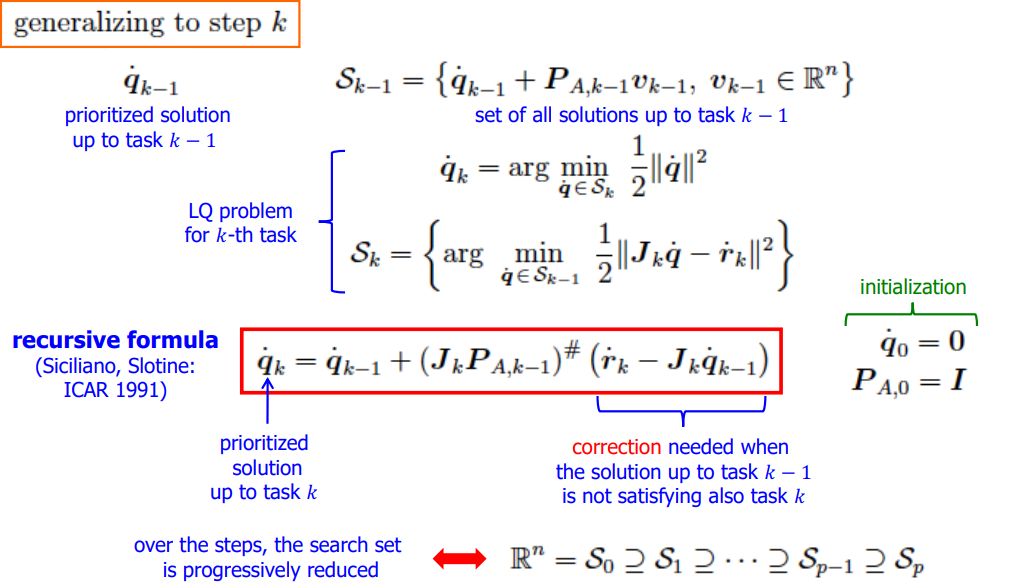

## Saturation in the Null Space (SNS)


### At velocity level

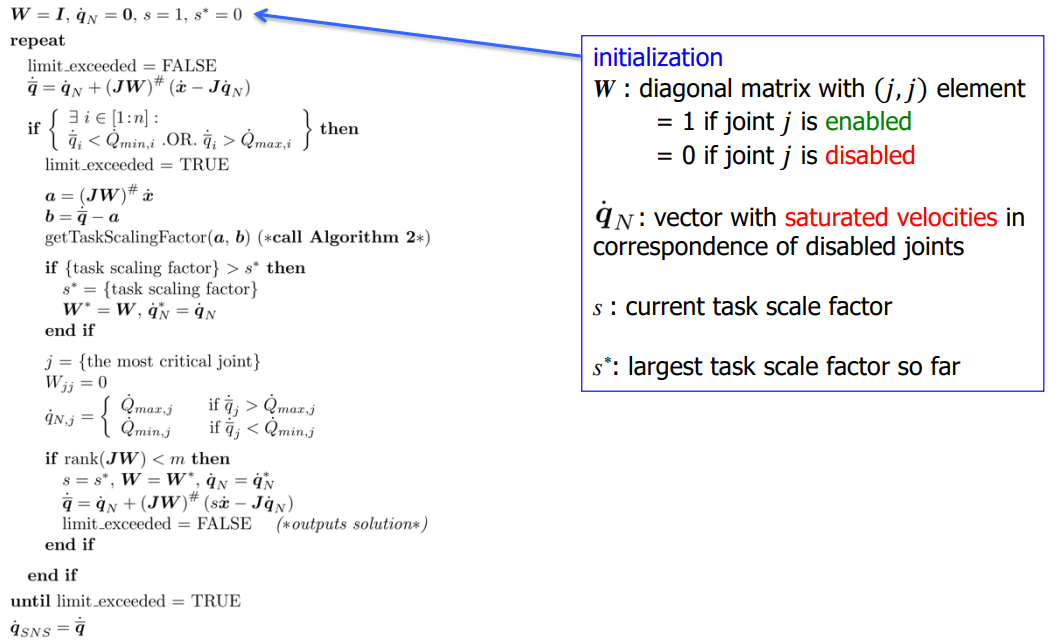

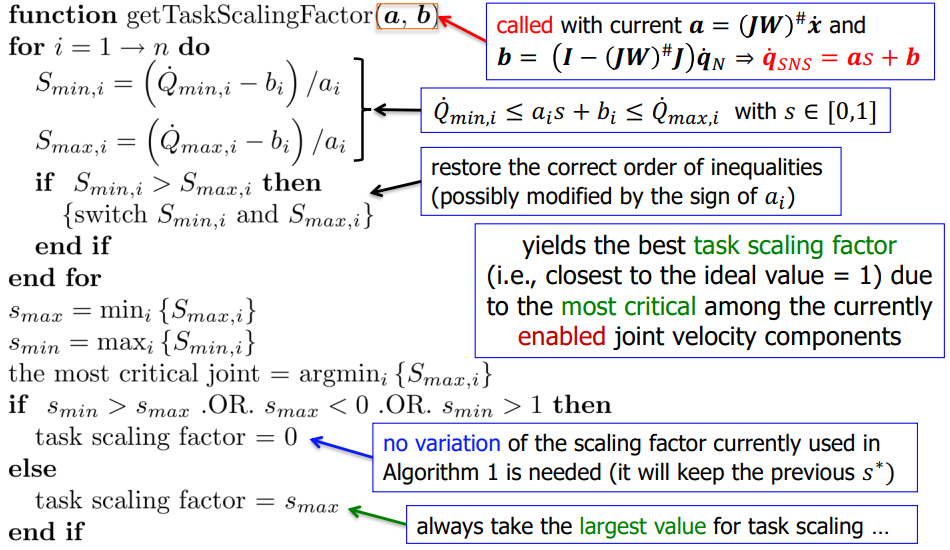

## Resolution at acceleration level

Given $r = f(q)$, $ṙ = J(q)q̇$, $r̈ = J̇(q)q̇ + J(q)q̈$ thus we obtain $q̈ = J^\#(q)ẍ + (I-J^\#(q)J(q))q̈_0$, where $q̈_0 = α∇_q H - K_d q̇$

In general if we're commanding at velocity level, we can regulate the position (the terms depending on the velocity should disappear), while if we're commanding at acceleration level we indirectly influence both velocity and acceleration.

## Dynamic redundancy resolution

Given the model $M(q)q̈+n(q,q̇)=τ$, we know that $J(q)q̈ = r̈-J̇(q)̇$.

The dynamic objectives to be locally minimized at $(q,q̇)$ can be:

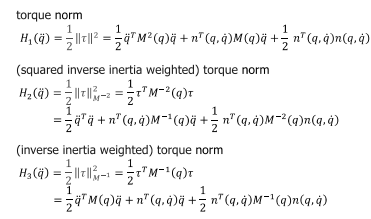

Whose solutions are:

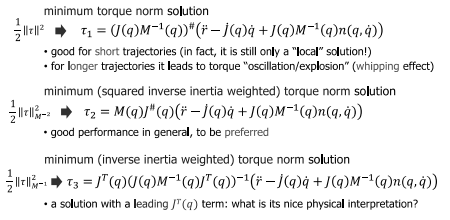

# Dynamic Model

The dynamic model of a robot provides the relation between generalized forces u(t) and the configuration q(t) (i.e. the effect of these forces applied on the system).

We can distinguish:

- **direct dynamics**: the input is the force u(t) and the output is the evolution over time of the generalized coordinate q(t)

- **inverse dynamics**: the input is the desired motion q(t) and the output is the force u(t)

There are two main approaches for dynamic robotics:
- Euler-Lagrangian method
- Newton-Euler method

Both models are equivalent.


## Euler-Lagrangian Method

The basic assumption is that the N links are considered as rigid bodies.

We start from the Lagrangian equation:

$L(q, q̇) = T(q, q̇) - U(q)$,
where $T$ is the kinetic energy and $U$ is the potential energy.

By deriving $L$ wrt $q$ and $q̇$ we get:

$d \over{dt}$$∂L \over ∂q̇_i$ $-$ $∂L \over ∂q_i$ $= u_i$.

$u_i$ can be a force or a torque, but also some dissipative forces as viscous, Coulomb, ...

### Robot kinetic energy
The robot kinetic energy is the sum of each kinetic energy of each link (+ base).

From the Konig Theorem we have the formula:

$T_i = {1\over2}m_iv_{ci}^Tv_{ci}+{1\over2}ω_i^TI_{ci}ω_i$

where $ω_i, I_{ci}$ should be expressed in the same reference frame.

Once all the components have been found, we can reorganize T as follows:

$T = {1\over2}q̇^T M(q) q̇$

where $M$ is the inertia matrix which is symmetric, positive definite i.e. always invertible.

### Robot potential energy

The robot potential energy is the sum of each potential energy of each link (+ base).
We assume that only gravity contributes to it.

For each link i we can write:

$U_i = -m_ig^Tr_{0,ci}$

If U is constant then $g(q)=0$.

where:
- $g$ is a gravity acceleration vector
- $r_{0,ci}$ is the position of the center of mass of link i

The robot dynamic model in vector form is:

$M(q)q̈ + c(q, q̇) + g(q) = u$

here $c(q,q̇)$ is a vector containing centrifugal and coriolis terms.
A generic k component of this vector is computed as:

$c_k(q,q̇) = q̇^TC_k(q)q̇$

where

$C_k(q) = {1\over2}({∂M_k\over∂q}+({∂M_k\over∂q})^T-{∂M\over∂q_k})$,

$M_k$ is the k-th column of M.

### Energy conservation

The total robot energy is $E = T+U$, if u = 0 the total energy is constant i.e. $Ė = 0$.


### Moving Frames

It is a method that allows to compute $v_{ci}$ and $ω_i$.

We set for i = 0:
- $^0v_0 = 0$
- $^0\omega_0 = 0$

and

- $σ_i = 0$ if i is revolute
- $σ_i = 1$ if i is prismatic
- $z_{i-1} = [0 \space 0 \space 1]^T$

Then:

$^i\omega_i = ^{i-1}R^T_i(q_i) [^{i-1}ω_{i-1} + (1-σ_i)q̇_i \space ^{i-1}z_{i-1}]$

$^iv_i = ^{i-1}R^T_i(q_i) [^{i-1}v_{i-1} + σ_iq̇_i ^{i-1}z_{i-1} + ^{i-1}ω_i Χ ^{i-1}r_{i-1,i}]$

$v_{ci} = v_i + ω_i Χ r_{ci}$




## State equations: direct dynamics

The Lagrangian model consists of N differential 2nd order equations. Now we want to define it in terms of 2N differential 1st order equations.

From the Lagrangian dynamic model:

$M(q)q̈ + c(q, q̇) + g(q) = u$,

then we define the vector of state variables as $x = [x_1 \space x_2]^T = [q \space q̇]^T$, thus, we can rewrite the model as:

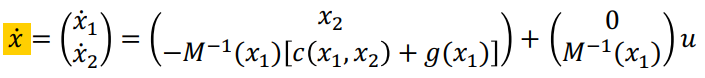





## Approximate linearization

We can also derive a linear dynamic model of the robot which is valid locally around a given operand condition.
The approximation is done through Taylor series expansion up to the first order.
The linearization is around a constant equilibrium state or along a time varying equilibrium trajectory.

In case of linearization at an equilibrium state we have:
$(q, q̇) = (q_e, 0), so q̈ = 0$ and $g(q_e) = u_e$

The variations around an equilibrium state become:

$q = q_e+Δq$

$q̇ = q̇_e+Δ\dot q = Δ\dot q$

$q̈ = q̈_e + Δq̈ = Δq̈$

$u = u_e + Δu$

In state space format we have $Δx = [Δq \space Δq̇]^T$:

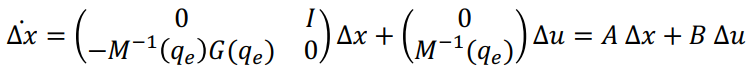

In case of linearization along a trajectory:
$(q, q̇) = (q_e, 0), so q̈ = 0$ and $g(q_e) = u_e$

The variations around an equilibrium state become:

$q = q_d+Δq$

$q̇ = q̇_d+Δ\dot q = Δ\dot q$

$q̈ = q̈_d + Δq̈ = Δq̈$

$u = u_d + Δu$

In state space format we have $Δx = [Δq \space Δq̇]^T$:

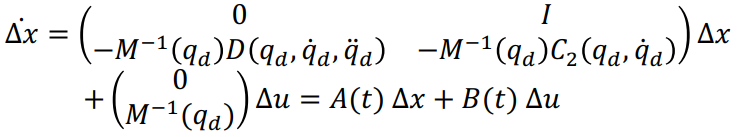

## Linear parametrization and identification of robot dynamics

Each link is characterized by 10 dynamic parameters: $m_i$, a scalar, $r_{ci}$ a vector of 3 elements and $I_{ci}$ which is a symmetric matrix (so only 6 elements are independent).

The robot depends only on some of them and possibly in a nonlinear way, but both the kinetic energy and the gravity potential energy can be rewritten
so that a new set of dynamic parameters appears only in a linear way through the vector $π_i$ for each link i.


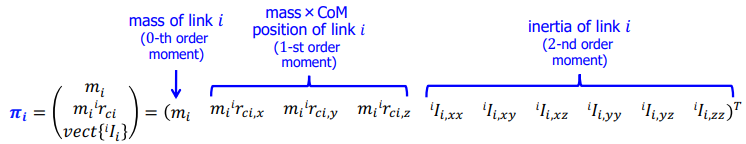

Using a NX10N regression matrix $Y_π$ that depends only on kinematic quantities, the robot dynamic equations can always be rewritten linearly in the standard dynamic parameters as:

$M(q)q̈ + c(q,q̇) + g(q) = Y_π(q, q̇, q̈) π = u$, where $Y_π$ has a block upper triangular structure.


## Newton-Euler Method

It deals with dynamic equations separately for each link/body and it is mainly used for inverse dynamics (equations are evaluated in a numeric and recursive way).

The Newton equation for a single rigid body is:

$∑_i f_i = {d\over dt}(mv_c) = mv̇_c$ which means that the sum of forces is equal to the variation of linear momentum.

The Euler dynamic equation is:

$∑_i u_i = {d\over dt}(Iω) = I ω̇ + ω Χ Iω$
which means that the sum of forces is equal to the variation of linear momentum.

In order to express the Newton-Euler equation we have to clarify the notation:

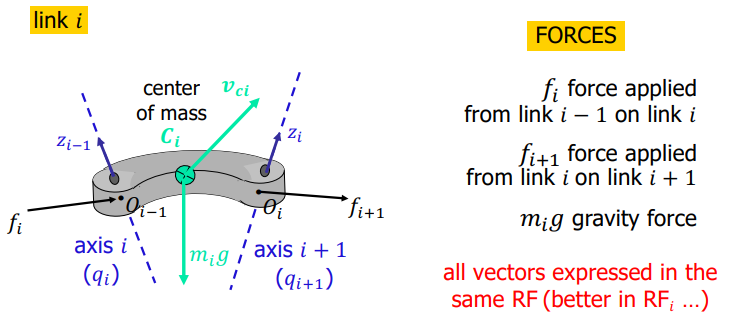

The Newton equation becomes:
$f_i - f_{i+1} + m_i g = m_i a_{ci} $

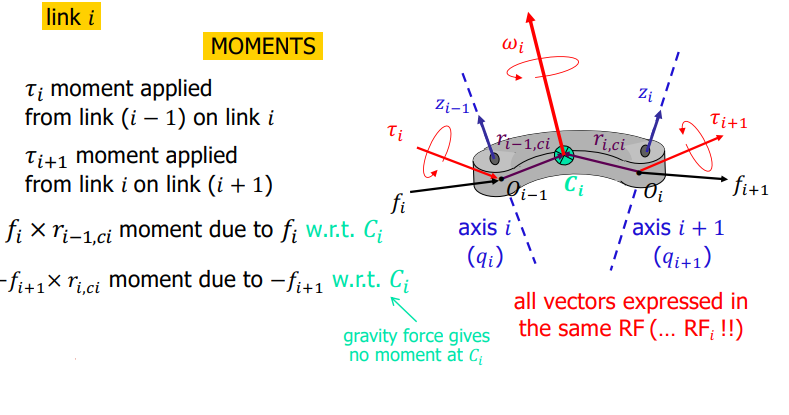

The Euler equation becomes:

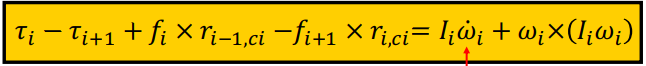

### Forward recursion

Assuming all revolute joints:

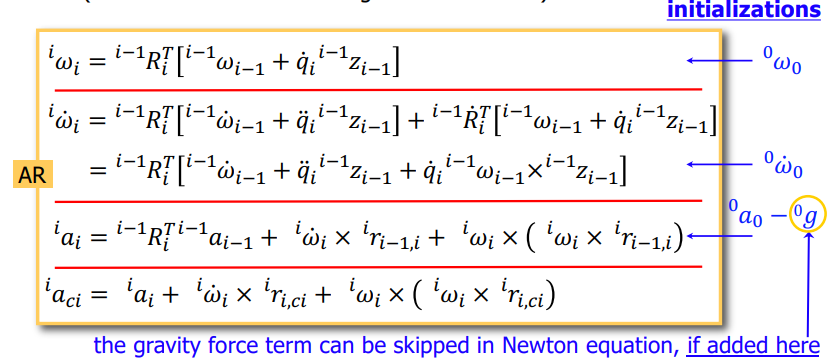

### Backward recursion

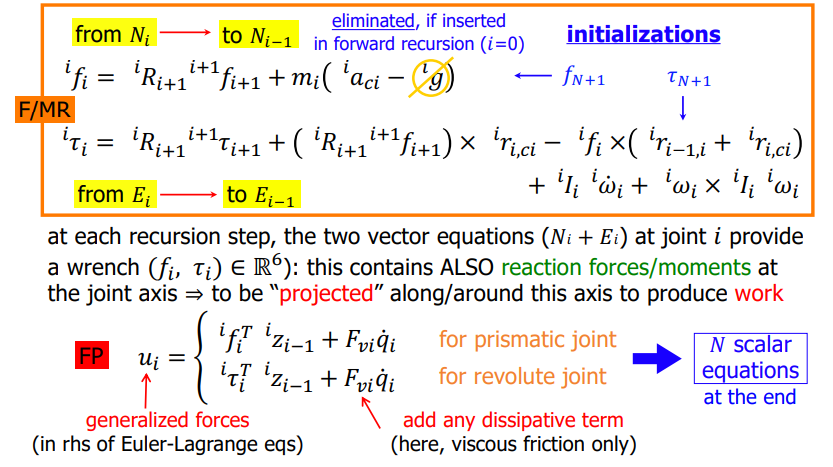

# Introduction to Control

Robot control aims to:
- successfully complete a task or work program
- have an accurate execution of a motion trajectory
- zeroing a positioning error

The control system unit has a hierarchical internal structure, going from the high level control (more intelligence, less precise) to the direct control (less intelligence, more precise).

We need to evaluate the control performance according to:
- quality of execution in nominal condition (velocity, accuracy, energy...)
- robustness in perturbed/uncertain conditions (adaption to changin environments,high repeatability despite disturbances, changes of parameters,
uncertainties, modeling errors, ...)

These performances can be improved by means of feedback, sensor information and learning.

There are two main types of control schemes:
- open loop: only feedforward part is included (control->robot->environment)
- closed loop commands: also feedback part is included

The best choice for a robot control scheme is the combination of the two.

There are many types of control schemes parts:
- feedback control: insensitivity to mild disturbances, small variations of parameters,
and different initial conditions
- robust control: tolerates relatively large uncertainties of known range
- adaptive control: improves performance online, adapting the control law to unknown
range of uncertainties and/or large (but slow) parameter variations
- intelligent control: performance improved based on trials/experience (learning), autonomous search and change of internal structure for optimizing
system behavior: SELF-ORGANIZING

The limits in control of industrial robots are a big issue and relate with:
- “closed” control architectures, relatively difficult to interface with
external programs and sensing devices for hard real-time operation
- need of some expertise for programming and handling of exceptions
- open-loop task command generation
- limited consideration of advanced kinematic and dynamic issues
- reduced execution speed (“control bandwidth”)
- reduced dynamic accuracy on fast motion trajectories
- problems with dry friction and backlash at the joints
- compliance in the robot structure

Thus, there exist more advanced robot control laws.

The functional structure of a control unit follows this scheme:

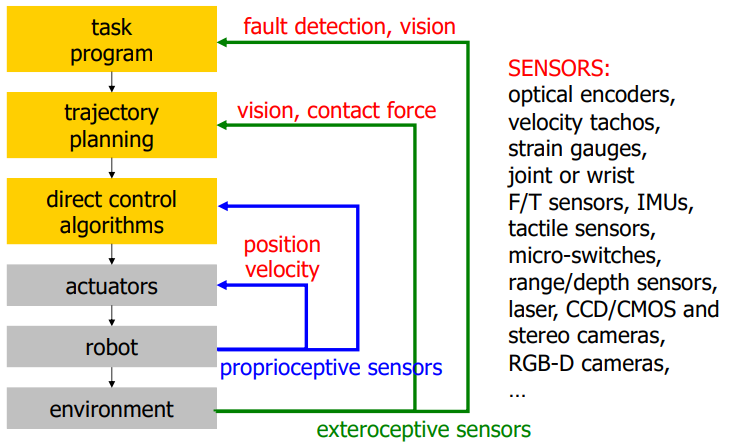

A panoramic view of control laws can be summerized as follows:

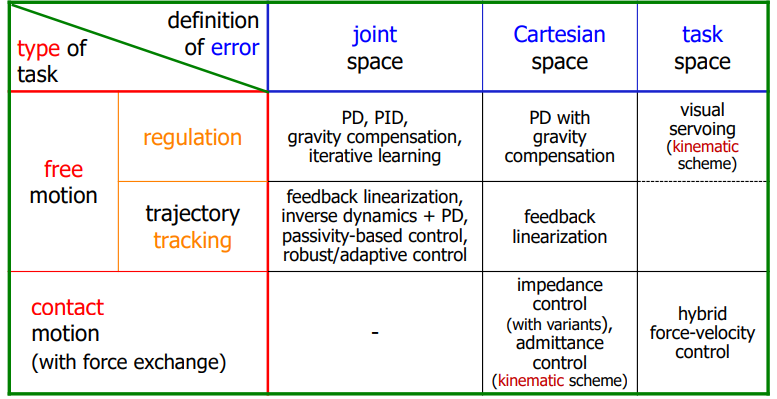

# Regulation

Starting from the state space equations, we have:

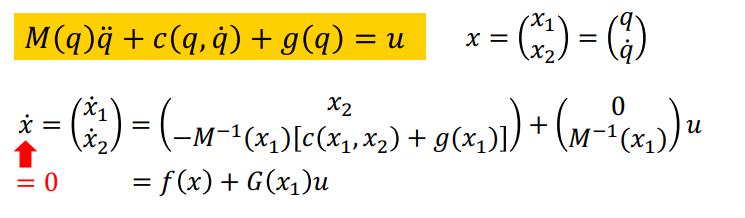

we can have 2 types of equilibrium:
- unforced equilibria: no command applied (u=0), for instance we have $ẋ= f(x_e)$ in this case the velocities ($x_{e,2}$) should be zero. Also the gravity terms are forces to be zero. This case is typical in mechanical systems.
- forced equilibria: we introduce an input $u = u(x)$, then we have $ẋ = f(x_e)+G(x_{e,1})u(x_e) = 0$
Again velocities should be zero and the controller should balance the gravity in order to have equilibrium.

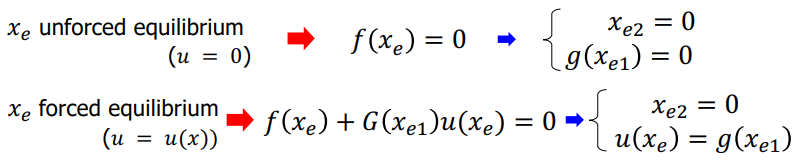



## Stability of dynamical systems

Let's sum up the equation $ẋ = f(x)$, the state equilibrium is reached when $f(x_e) = 0$.

The stability of $x_e$ is defined as follows:

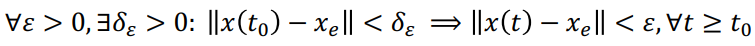

So we have stability when small perturbations will produce small effects.

We have asymptotic stability when:

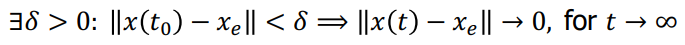

So it is a stronger stability because already the previous condition is satisfied, but we add that the trajectory will converge to the desired one, once t grows.

Then we have a third definition which relates with exponential stability of $x_e$:

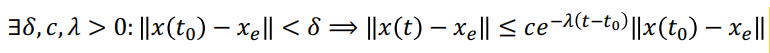

The error in future times is bounded by an initial error and an exponential term. It allows to estimate the time needed to approximately converge. This stability is even strbìonger than asymptotic stability.

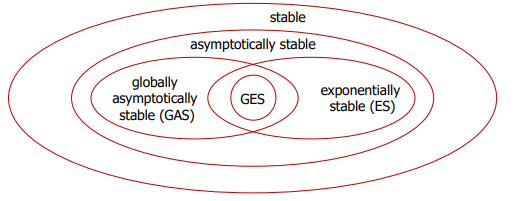

Practical stability is instead related to a set S.


A Lyapunov candidate is a positive definite function in the form:

$V(x):R^n -> R$ s.t. $V(x_e) = 0, V(x)>0$, $∀ x \neq x_e$

How do we build this function? Typically it is quadratic e.g. ${1\over2} (x-x_e)^T P (x-x_e)$.
This function may also be a local candidate (not for all x != x_e, but only in a neighborhood).

The sufficient condition of stability states that:

$∃V$ candidate s.t. $V̇(x)<=0$, evaluated along the trajectories of $ẋ = f(x)$

The sufficient condition of asymptotic stability states that:

$∃V$ candidate s.t. $V̇(x) < 0$, evaluated along the trajectories of $ẋ = f(x)$

The sufficient condition of instability states that:

$∃V: V̇(x)> 0$, along the trajectory of $ẋ = f(x)$

The LaSalle Theorem states that:

if $∃ V: V̇(x)<=0$ along the trajectories of $ẋ = f(x)$ then system trajectories asymptotically converge to the largest invariant set $M \subseteq S$ = ${{x \in R^n : V̇(x) = 0}}$.

$M$ is invariant if $x(t_0) \in M -> x(t) \in M, ∀t>=t_0$.

Corollary: $M ≡ {{x_e}}$ -> asymptotic stability.

Previous results are also valid for periodic time-varying systems:

$ẋ = f(x,t) = f(x, t+T_p)$ -> $V(x,t) = V(x,t+T_p)$

The Barbalat Lemma states that:
if
- a function $V(x,t)$ is lower bounded
- $V̇(x,t)<= 0$
then $∃ \lim_{t\to \infty} V(x,t)$
if (in addition)
- $V̈(x,t) is bounded$
then $\lim_{t\to \infty} V̇(x,t) = 0$

Corollary:
if a Lyapunov candidate $V(x,t)$ satisfies Barbalat Lemma along the
trajectories of $ẋ=f(x,t)$ then the conclusions of LaSalle Theorem hold.

The practical stability of a set S (u.u.b. stability):
$∃T(x(t_0), S) ∈ R: x(t) \in S, ∀t>=t_0+T(x(t_0), S)$

The sufficient condition of u.u.b. stability of a set S is:
$∃ V: $
1. S is a level set of V for a given $c_0$
2. $V̇(x)< 0$ along trajectories of $ẋ = f(x), x∉S$




## Stability of linear systems

$ẋ = Ax$, $x_e$ is always an equilibrium state.

If $x_e = 0$ is an asymptotically stable equilibrium, then it is necessarily the unique equilibrium

## Stability of the linear approximation

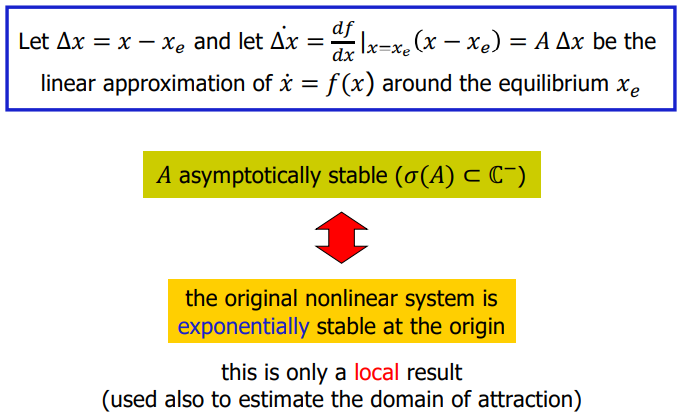

## PD control

PD control law combines a proportional (P) control which provides a correction based on the current error between the desired and actual position, and a derivative (D) control which provides a correction based on the rate of change of the error (the error derivative).

It is one of the simplest control law.
Consider the robot in its full dynamics, the goal is to regulate (obtain AS) of a desired equilibrium state: $q = q_d, q̇ = 0$.

The desired controller is in the form
$u = K_p(q_d-q)-K_dq̇$, where $K_p>0, K_d>0$ and symmetric, typically diagonal.

Theorem: in absence of gravity, the robot state $(q_d, 0)$ under the given PD control law is globally asymptotically stable.

*(proof in the slide)*

Also in presence of gravity, we can show that the control law
$u = K_p(q_d-q)-K_dq̇ + g(q)$ will make the equilibrium state asymptotically stable.

If we don't know exactly $g(q)$, but only an approximation of it $ĝ(q)$, the control law is:
$u=K_P(q_d-q)-K_D+ĝ(q)$, we will have a steady state position error with a steady state configuration $q* \neq q_d$. In this configuration the gravity is constant and acts as a disturbance and since the control has no integral action then we will have this kind of error.
It can be reduced by choosing $K_P$ large enough, or we need to introduce an integral action.


1. The choice of control gains affects robot evolution during transients and
practical settling times:
  - hard to define values that are “optimal” in the whole workspace
  - “full” U/ and U1 gain matrices allow to assign desired eigenvalues
  to the linear approximation of the robot dynamics around the final
  desired state $(q_d, 0)$

2. when (joint) viscous friction is present, the derivative term in the
control law is not strictly necessary:
  - $-F_Vq̇$ in the robot model acts similarly to $-K_Dq̇$ in the control law, but the latter can be modulated at will

3. in the absence of tachometers, the actual realization of the derivative
term in the feedback law requires some processing of joint position
data measured by digital encoders (or analog resolvers/potentiometers)

## PD control + constant gravity compensation

We add here a constant term which compensate gravity only at the destination. So we will introduce a term $g(q_d)$.

If the robot potential energy U(q) is bounded for all q, then its partial derivative
g(q) is also bounded everywhere and the following structural property holds:

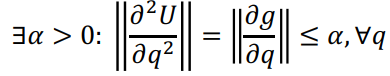


The consequence is:

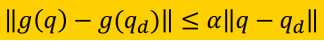

Of course, the terms inside the norms are vectors, so we use the following
norm:

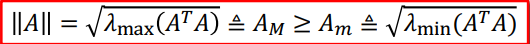

On the leften side we have parameters that depend on the model, while on the other side they don't so we can use them for the analysis.


And the resulting linear control law is:

$u = K_p(q_d-q)-K_Dq̇ + g(q_d)$

when is the (non-zero) gravity term g(q) bounded for all q?
- the robot has all revolute joints
- the robot has both types of joints, but no prismatic variables in g(q)
- all prismatic joints of the robot have a limited range

Theorem:
If $K_{P,m}>α$ the state $(q_d, 0)$ of the robot under joint-space PD control + constant gravity compensation at $q_d$ is globally asymptotically stable.

(*proof on the slide*)

## Approximate gravity compensation
The approximate control law is

$u = K_P(q_d-q)-K_Dq̇ + ĝ(q_d)$

and it leads under similar hypotheses, to a closed-loop equilibrium q*. Its uniqueness is not guaranteed (unless $K_P$ is large enough) and for $K_P -> ∞$, one has $q*->q_d$


## PID control

In linear systems, the addition of an integral control action is used
to eliminate a constant error in the step response at steady state.

In robots, a PID may be used to recover such a position error due
to an incomplete (or absent) gravity compensation/cancellation.

The control law is:

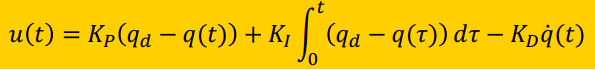

- It is independent from any robot dynamic model term.
- If the desired closed-loop equilibrium is asymptotically stable under PID control, the integral term is "loaded" at steady state to the value:

  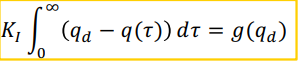
- however, one can show only local asymptotic stability of this law

## Saturated PID control

More in general, one can prove global asymptotic stability of $(q_d, 0)$,
under lower bound limitations for $K_P, K_l, K_D$ (depending on suitable
“bounds” on the terms in the dynamic model), for a nonlinear PID law


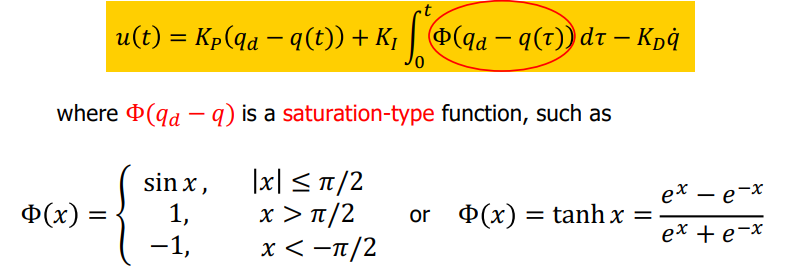




## Limits of robot regulation controllers

- response times needed for reaching the desired steady state are not
easily predictable in advance
  - depend heavily on robot dynamics, on PD/PID gains, on the required
  total displacement, and on the interested area of the robot workspace
  - integral term (when present) needs some time to “unload” itself from
  the error history accumulated during transients
  - large initial errors are stored in the integral term
  - anti-windup schemes stop the integration when commands saturate
  - … an intuitive explanation for the success of “saturated” PID law
- control efforts in the few first instants of motion typically exceed by far those required at steady state
  - especially for high positional gains
  - may lead to saturation (hard nonlinearity) of robot actuators


## Regulation in industrial robots

In industrial robots, the planner generates a reference trajectory $q_r(t)$ even when the task requires only positioning / regulation of the robot.

$q_r(t)$ is used within a control of the form:

$u = K_P(q_r(t)-q)+K_D(q̇_r(t)-q̇)+g(q)$


# Iterative Learning for Gravity Compensation

It is an alternative method for achieving compensation in presence of gravity.
This will be done without:
- explicit knowledge of robot dynamic coefficients (nor of
the structure of the gravity term)
- the need of “high” position gain
- complex conditions on the control gains


The iterative learning is a process based on an iterative control scheme able to learn while executing the task.

This control scheme will use:
1. PD control on joint position error + constant feedforward term
2. iterative update of the feedforward term at successive steadystate conditions

The goal is to derive sufficient conditions for the global convergence
of the iterative scheme with zero final error.

We will use Euler Lagrange dynamic model of the robot and we assume the existence and knowledge of a bounded term $α$ on the gradient gravity term.


What happens when we try to regulate with a PD control law (without gravity cancellation nor compensation) is that at steady state there is a non-zero error left $ē = q_d-q̄ \neq 0$

So we slightly modify the PD control law with a constant compensation term and we add a positive factor gamma to the proportional matrix gain.
At the i-th iteration we should have:

$u = γK_P(q_d-q)-K_Dq̇ + u_{i-1}$,

where $q_0$ is the initial configuration of the robot, $u_0 = 0$ is the easiest initialization of u. (So at the first iteration we have a PD control law more or less).

At the steady state of the i-th iteration ($q=q_i, q̇=0$) one has:

$g(q_i) = γK_P(q_d-q_i)+u_{i-1}$

So this righten term compensates gravity.

The update law of the compensation term is:

$u_i = γK_P(q_d-q_i)+u_{i-1}$

## Convergence analysis

Theorem:

if

a. $λ_{min}(K_P)>α$
b. $γ>=2$

then, we garantee that the sequence $q_0, q_1, q_2,...$ converges to $q_d$ (and $q̇=0$) from any initial value $q_0$ (and $q̇_0$), i.e., globally.

The condition (a) is sufficient for the global asymptotic stability
of the desired equilibrium state when using $u=K_P(q_d-q)-K_Dq̇+g(q_d)$, with a known gravity term and diagonal gain matrices.

The additional sufficient condition (b) guarantees the
convergence of the iterative scheme.

(*proof on the slide*)

Combining (a) and (b), the sufficient condition only requires the
doubling of the proportional gain w.r.t. the known gravity case
$K̂_P = γK_P$

$λ_{min}(K̂_P)>2α$

For a diagonal $K̂_P$, this condition implies a (positive) lower bound
on the single diagonal elements of the matrix. Again, this is only a sufficient condition (the scheme may converge even if this condition is violated).
The scheme can be interpreted as using an integral term that is updated only in correspondence of a discrete sequence of time instants with a guaranteed global convergence (and implicit stability).

- only few iterations are needed for obtaining convergence,
learning the correct gravity compensation at the desired $q_d$
- sufficiency of the condition on the P gain
  - even if violated, convergence can still be obtained (first two cases);
  otherwise, a limit motion cycle takes place between two equilibrium
  configurations that are both incorrect (as in the third case)
  - this shows ‘how far’ is sufficiency from necessity
- analysis can be refined to get lower bounds on the $K_{P,i}$ (diagonal
case) that are smaller, but still sufficient for convergence
- intuitively, lower values for $K_{P,i}$ should still work for distal joints
- in practice, update of the feedforward term occurs when the robot is close enough to a steady state (joint velocities and
position variations are below suitable thresholds)



# Trajectory Tracking Control

There are a lot of differences from the nominal condition:
- the initial state doesn't match with the desired trajectory
- actuators can be disturbed by unexpected collisions, truncation errors on data, ...
- we have inaccurate knowledge of the robot dynamic parameters
- the curried payload value is unknown
- there may be some unmodeled dynamics

For those disturbances we require the feedback part.

We define the inverse dynamic model in the Euler-Lagrangian form as $M(q)q̈ + n(q,q̇) = u$, where $n(q, q̇) = c(q,q̇)+g(q)$ + friction model.
Assuming a twice-differentiable desired trajectory for $t ∈ [0,T], q_d(t)$, we can formulate the feedforward torque in nominal conditions:
$u_d = M(q_d)q̈_d + n(q_d, q̇_d)$

If we take into account the possible errors of measurements and disturbances listed above, we can rewrite:

$u_d̂ = M̂(q_d)q̈_d + n̂(q_d, q̇_d)$, $M̂, n̂$ are estimates of terms in the dynamic model.

Now, feedback is introduced to make the control scheme more robust.
There are different implementations of it.
The control design has here 2 steps:
- in the firs one we try to handle the non linearities by compensating with feedforward or cancelling them with feedback.
- in the second one, the resulting linear system (obtained with the first step) we stabilize the trajectory error to zero.

There are a list of trajectory controllers:

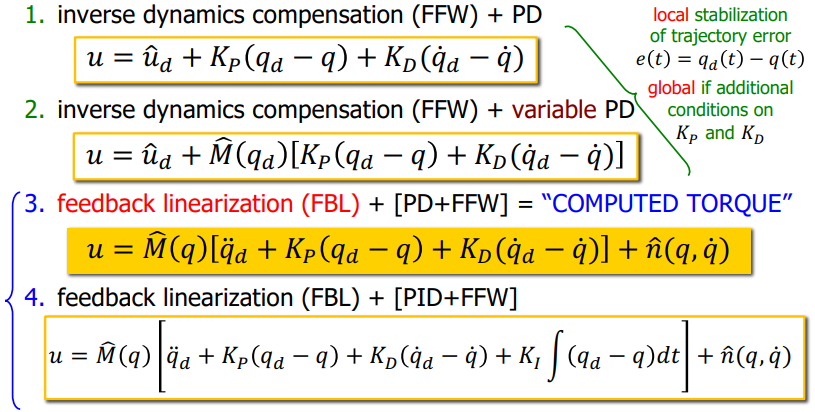


In the first one, we choose $K_P, K_D$ positive definite. They multiply them respectively with the configuration error and the velocity error.

In the second one, we use also the estimate $M̂$ evaluated in the desired trajectory that multplites the gains. The reason is that we modulate the constant gains by the inertia along the desired trajectory so that the effective proportional and derivative gains are amplified (if M is high) otherwise they will be reduced (if M is low)

These first two work well when the error is small and they are applied onlyfor local stabilization of trajectory error.

The third one uses the inertia matrix evaluated on the actual trajectory (so on the current configuration q), then we use an additional feedforward related to the acceleration.

The last one is a slight variation of the previous one, adding an integral term which compensate constant uncertainty.

The most common one is the third one, the feedback linearization control.

Under feedback linearization control, the robot has a dynamic behavior that is
invariant, linear and decoupled in its whole state space.
Linearity means that error transients go to zero exponentially, prescribed by $K_{P,i}, K_{D,i}$. The shape of the error transients are related to the choice of the diagonal elements of the gain matrices.
Decoupling means that each joint coordinate $q_i$ evolves independently from the others, forced by $a_i$.


The desired joint trajectory can be generated from Cartesian data.

Other notes:
- the parametric identification should be done in advance.

- the choice of the sampling time of a digital implementation should be found as a compromise between computational time and tracking accuracy.
- the exact linearization by (state) feedback is a general technique
of nonlinear control theory.

## Alternative global trajectory controller

$u = M(q)q̈_d + S(q,q̇)q̇_d + g(q) + F_V q̇_d + K_Pe + K_Dė$

Here, the gains are not premultiplied by the inertia matrix.
We use a special factorization of centrifugal and coriolis terms S s.t. $Ṁ - 2S$ is skew symmetric. Also, we assume the gain matrices to be symmetric and positive definite.

This is a controller that achieves global asymptotic stability of $(e, ė) = (0,0)$.
This property can be shown by Lyapunov + Barbalat + LaSalle. (proof in the slide)

Also, this controller doesn't produce a complete cancellation of nonlinearities of the dynamic model. Moreover it doesn't induce a linear and decoupled behavior of the trajectory error $e(t)=q_d(t)-q(t)$ in closed loop system.
It cannot be computed directly by the standard NE algorithm.
The positive property it has is that it lends itself more easily to an adaptive version.


If $q_d$ is constant, the feedback linearization has no special simplifications, but this is a solution to the regulation problem with exponential stability; the alternative global controller becomes the simpler PD + gravity cancellation control law.

## Trajectory execution without a model

Is it possible to accurately reproduce a desired smooth jointspace reference trajectory with reduced or no information on the robot dynamic model?
This is feasible (and possibly simple) in case of repetitive motion
tasks over a finite interval of time:
- trials are performed iteratively, storing the trajectory error
information of the current execution [k-th iteration] and
processing it off line before the next trial [(k + 1)-iteration] starts
- the robot should be reinitialized in the same initial state at the
beginning of each trial (typically, with $ q̇ = 0$)
- the control law is made of a non-model based part (often, a
decentralized PD law) + a time-varying feedforward which is
updated before every trial

This scheme is called iterative trajectory learning.
It can be designed as:


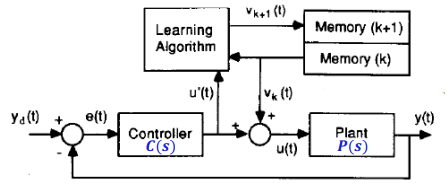

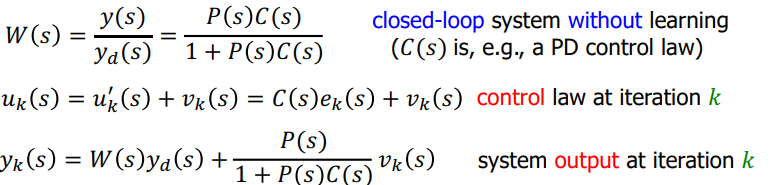

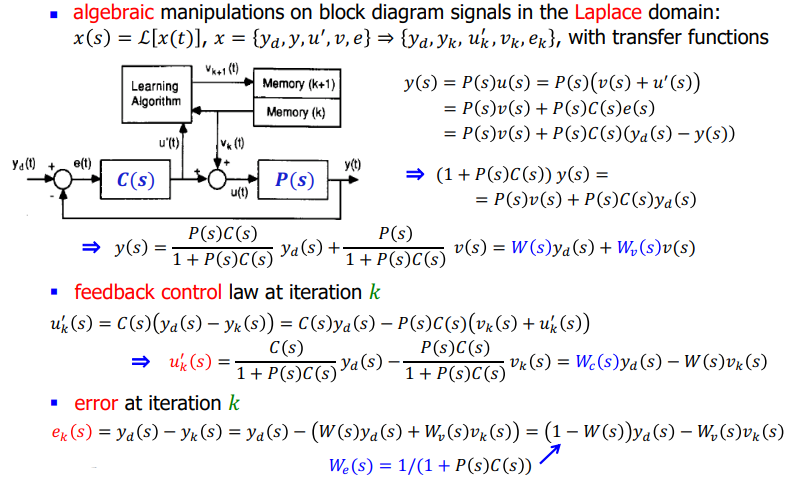


the update of the feedforward term is designed as:
$v_{k+1} (s) = α(s)u'_k(s)+β(s)v_k(s)$, where $α, β$ are suitable filters.

Also, both the feedforward and error term have a recursive expression:

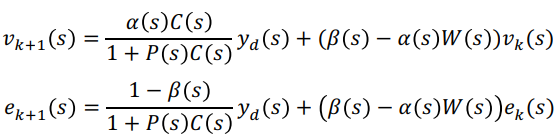


If a contraction condition can be enforced ($| β(s)-α(s)W(s)| < 1$), then convergence is obtained for $k->∞$

if the choice $β= 1$ allows to satisfy the contraction condition, then
convergence to zero tracking error is obtained $e_∞ (s) = 0$ and the inverse dynamics command has been learned $v_∞ (s) = {y_d(s)\over{P(s)}}$.

For $\alfa (s) = {1\over {W(s)}}$ convergence is reached in 1 iteration only.

If $β$ is not 1, it is possible to obtain convergence even in presence of unmodeled high-frequency dynamics.

## Application to robots

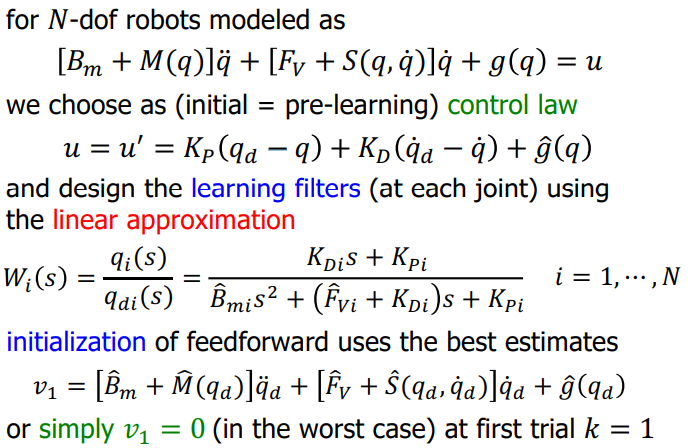



# Adaptive Trajectory Control


The goal of adaptive control is to execute a twice differentiable desired joint trajectory (with known desired velocity and acceleration) under large dynamic uncertainties with a trajectory tracking error vanishing asymptotically, guaranteeing global stability.

We will use linear parametrization of robot model $Y(q,q̇, q̈) α = u$ can always be found starting from a (Euler-Lagrange) dynamic expression of the robot.
The vector α contains only unknown or uncertain coefficients and each component is in general a combination of the robot physical parameters.
The model regression matrix $Y$ depends linearly on $q̈$, quadratically on $q̇$ and nonlinearly on $q$.

Typically we use and update estimates so as to reduce the error to zero.

We may use a controller made up of two parts the inverse dynamics feedforward (FFW) and a PD linear control:

$u = M̂(q_d)q̈_d + Ŝ(q_d,q̇_d)q̇_d + ĝ(q_d) + F̂_V q̇_d + K_P e + K_D ė$.

or a nonlinear controller based on feedback linearization:

$u = M̂(q)(q̈_d + K_Pe + K_D ė) + Ŝ(q,q̇)q̇ + ĝ(q) + F_V̂ q̇$.

When using estimates in the FBL there might be some problems due to instability because of non positive PD gains.

So, we can think to work with a nonlinear trajectory tracking control having global asymptotic stabilization properties:

$u = M̂(q_d)q̈_d + Ŝ(q_d,q̇_d)q̇_d + ĝ(q_d) + F̂_V q̇_d + K_P e + K_D ė$

This controller doesn't require cancellations.

Our problem now is to estimate $α̂̇$ by designing a suitable update law in continous time.
With this estimation we have zero velocity error but a residual position error may be left.
For instance we use a online modification with a reference velocity:

$q̇_r = q̇_d +Λ(q_d-q) $, $Λ > 0$, (typically $Λ = K_D^{-1}K_P$ ).

Now we substitute $q̇_r$ in the controller and obtain:

$u = Y(q, q̇, q̇_r, q̈_r)α̂ + K_P e + K_D ė$

The update law for the estimates of the dynamic coefficients is:

$â̇ = ΓY^T (q,q̇,q̇_r,q̈_r)(q̇_r - q̇)$, where $Γ$, (>0 and diagonal) represents the estimation gains.

Theorem:

The introduced adaptive controller makes the tracking error along the desired trajectory globally asymptotically stable.
(*proof on the slide*)

Notes:
- if the desired trajectory is persistently exciting, then also the
estimates of the dynamic coefficients converge to their true values
- condition of persistent excitation
  - for linear systems: # of frequency components in the desired trajectory
  should be at least twice as large as # of unknown coefficients
  - for nonlinear systems: the condition can be checked only a posteriori
  (a squared motion integral should always be positive bounded from below)
- the adaptive controller does not require the inverse of the inertia
matrix (true or estimated), nor the actual robot acceleration (only the
desired acceleration), nor further lower bounds on $K_P>0, K_D>0$
- adaptation can also be used only for a subset of dynamic coefficients,
with the others being known
- the non-adaptive version (using accurate estimates) is a static
tracking controller based on the passivity property of robot dynamics


# Control in the Cartesian Space

The error is defined here at the end effector level so in the cartesian space.

The first type of controller is used for regulation of robot cartesian space.
We consider the dynamics in the form:
$M(q)q̈+S(q,q̇)q̇+g(q) = u$ and the direct kinematics $p=f(q)$, $ṗ = J(q)q̇$. We use as notation $n$ the dimension of joint space and $m$ of cartesian space.

The goal is having an asymptotic stabilization of the end effector pose, namely $p=p_d, q̇=0, ṗ_d = 0$.

If $n=m$, then $q̇=0$ iff $ṗ=0$ up to singularities.
If $n>m$, then the goal is not uniquely assiciated to a complete robot state.

## Cartesian regulation law

$u=J^T(q)K_P(p_d-p)-K_Dq̇ + g(q)$

Theorem:
Under this control law, the robot state will converge asymptotically to the set $A={q̇=0, q:K_P(p_d-f(q)) ∈ N(J^T(q))}$

(*proof on the slide*)

Corollary:

for a given initial state  $(q(0),q̇(0))$, if the robot does not
encounter any singularity of $J^T(q)$ during its motion,  then there is asymptotic stabilization to one single state (when m = n) or to a set of
states (when m < n) such that $e_p = 0, q̇=0$.

A possible variant for regulation can be:

$u=J^T(q)[K_P(p_d-p)-K_Dqṗ] + g(q)$

So, we have all cartesian PD control and a gravity cancellation in joint space.

## Feedback linearization in Cartesian space

Theorem:

For a non-redundant robot, it is possible to exactly linearize and
decouple the dynamic behavior at the Cartesian level if and only if det(J(q)) != 0.

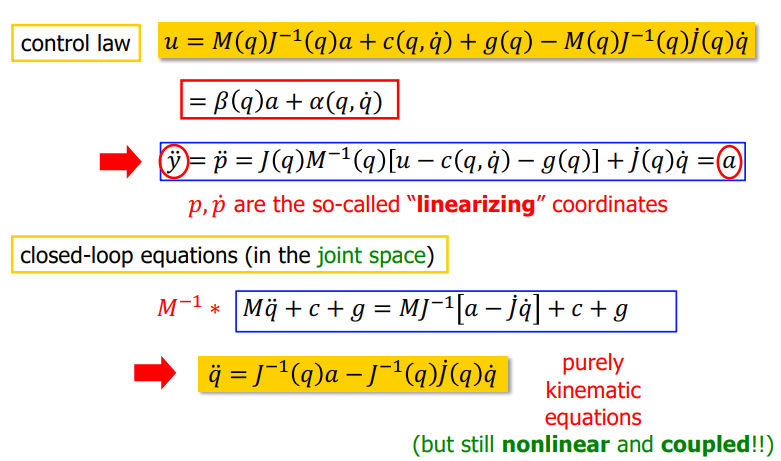

Notes:
- the design of a Cartesian trajectory tracking control is completed
by stabilizing the tracking error in the m independent chains of
double integrators
- the transient behavior of the Cartesian error along a desired
trajectory is exponentially stable (with arbitrary eigenvalues
assigned by choosing the diagonal gains of $K_P,K_D$)
- for $p_d$ = costant the control law becomes:

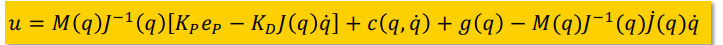

- the Cartesian pose/velocity can either be directly measured by
external sensors (cameras: eye-to-hand/eye-in-hand) or
computed through direct and differential kinematics of the robot
- in redundant robot by replacing $MJ^{-1} = (JM^{-1})^{-1}$ in the control law with some (weighted) pseudoinverse $(JM^{-1})^\#_W $ one still obtains input-output decoupling and linearization but not exact linearization of the whole state dynamics.
- most of the control laws presented in the joint space
(i.e., driven by a joint error) can be translated with
relative ease to the Cartesian space, e.g.
  - regulation with constant gravity compensation
  - adaptive regulation
  - robust control for trajectory tracking
  - adaptive control for trajectory tracking
- the main issues are related to
  - kinematic singularities, both for the Jacobian transpose and
  the Jacobian inverse control laws: suitable modifications are
  needed to obtain singularity robustness
  - kinematic redundancy (m < n): use of a stabilizing null-space
  torque control is needed for the extra n-m generalized
  coordinates (locally, n-m joint variables)

# Robot Interaction with the Environment

A robot may interact with the environment, modifying its state or by exchanging forces.

The robot compliance can be:
- passive: robot end-effector equipped
with mechatronic devices
that “comply” with the
generalized forces applied at
the TCP = Tool Center Point
- active: robot is moved by a control
law so as to react in a desired
way to generalized forces
applied at the TCP (typically
measured by a F/T sensor)

The possible tasks with environment interaction are:
- mechanical machining
- tele-manipulation
- contact exploration for shape identification
- dexterous robot hands
- cooperation of multi-manipulator systems
- physical human-robot interaction

The tasks of interest are those requiring:
- accurate following / reproduction by the robot end-effector of desired trajectories (even at high speed) defined on the surface of objects,  
- control of forces/torques applied at the contact with environments having low/soft or high/rigid stiffness.

For physical interaction tasks, the desired motion
specification and execution should be integrated with
complementary data for the desired force.

The exchanged forces/torques at the contact(s) with the
environment can be explicitly set under control or simply
kept limited in an indirect way.

We talk about impedance control when
- the environment is a mechanical system with small but finite deformations.
- contact forces arise as the result
of a balance of two coupled
dynamic systems
So, the desired dynamic characteristics
are assigned to the force/motion
interaction

We talk about hybrid force/motion control
when:
- a rigid environment reduces the
degrees of freedom of the robot
when in (bi-/uni-lateral) contact
- contact forces result from attempts
to violate geometric constraints
imposed by the environment

So, task space is decomposed in sets
of directions where only motion or
only reaction forces are feasible.


## Constrained robot dynamics

Consider the generic lagrange dynamic model and a task output function r=f(q),
suppose that the task variables are subject to m < n (bilateral)
geometric constraints in the general form k(r) = 0 and define h(q) = k(f(q)) = 0.

The constrained robot dynamics can be derived using again the
Lagrange formalism, by defining an augmented Lagrangian as

$L_a(q,q̇,λ)=L(q,q̇)+λ^Th(q)=T(q,q̇)-U(q)+λ^Th(q)$,

where the Lagrange multipliers λ (a m-dimensional vector) can
be interpreted as the generalized forces that arise at the contact
when attempting to violate the constraints.

Applying the Euler-Lagrange equations in the extended space of
generalized coordinates q and multipliers λ yields:

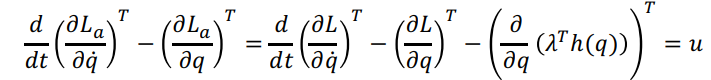

Contact forces don't produce work:

${∂L_a \over ∂λ}^T = h(q) = 0$

We can now define the dynamic model in the form:

$M(q)q̈+c(q,q̇)+g(q)=u+A^T(q)λ$

subject to

$h(q)=0$

$A(q)= {∂h(q) \over ∂q}$ and we assume A to be full rank

We can also eliminate the appearance of the multipliers by differentiating the constraints twice wrt time and substitute the joint accelerations from the dynamic model. At this point we have a formula for the constraint forces λ which are uniquely determined by the robot state $(q, q̇)$ and input $u$.

The final constrained dynamic model can be rewritten as:

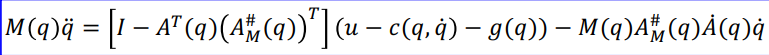

If the robot state $(q(0), q̇(0))$ satisfies the constraints i.e. h(q(0))=0 and $A(q(0))q̇(0)=0$, then the robot evelution described by the above dynamics will be consistent with the constraints for all t>=0 and for any u(t).

## Reduced robot dynamics

By imposing m constraints h(q)=0 on the n generalized coordinates q, it is also possible to reduce the description of the constrained robot dynamics to a n-m dimensional configuration space.

We start from constraint matrix A(q) and select a matrix D(q) such that by stacking A and D by rows, the resulting matrix is non singular and there exists the inverse matrix:

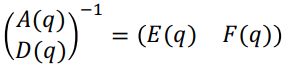

Then we define the (n-m)-dimensional vector of pseudo velocities v as:
$v = D(q)q̇$, $v̇ = D(q)q̈+Ḋ(q)q̇$, while the inverse relationships are given by:
$q̇=F(q)v$, $q̈ = F(q)v̇-(E(q)Ȧ(q)+F(q)Ḋ(q))F(q)v$

We can obtain the reduced (n-m)-dimensional dynamic model:

$Mq̈ + c+ g = u +A^T\lambda$

$E^T(Mq̈+c+g-u)=λ$

$F^TMq̈ = F^T (u-c-g)$

substituting in the latter the generalized accelerations and velocities
with the pseudo-accelerations and pseudo-velocities leads finally to:

$(F^TMF)v̇ = F^T(u-c-g+M(EȦ+FḊ)Fv)$

The expression of the multipliers becomes:

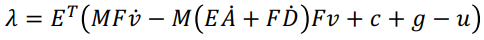

### Control based on reduced robot dynamics

The reduced n - m dynamic expressions are more compact but also
more complex and less used for simulation purposes than the
m-dimensional constrained dynamics.
however, they are useful for control design (reduced inverse dynamics), in fact, it is straightforward to verify that the feedback linearizing
control law:

$u=(c+g-M(EȦ+FḊ)Fv)+MFu_1-A^Tu_2$

applied to the reduced robot dynamics and to the expression of
the multipliers leads to the closed-loop system $v̇ = u_1$, $λ=u_2$



# Hybrid Force/Motion Control

We consider contacts/interactions between a robot and a stiff
environment that naturally constrains the end-effector motion.

Compared to an approach using the constrained/reduced robot
dynamics with (bilateral) geometric constraints, the differences are
- the hybrid control law is designed in ideal conditions, but now
unconstrained directions of motion and constrained force directions
are defined in a more direct way using a task frame formalism
- all non-ideal conditions (compliant surfaces, friction at the contact,
errors in contact surface orientation) are handled explicitly in the
control scheme by a geometric filtering of the measured quantities
  - considering only signal components that should appear in certain
  directions based on the nominal task model, and treating those that
  should not be there as disturbances to be rejected

The hybrid control law avoids to introduce conflicting behaviors
(force vs. motion control) in any of the task space directions!!

## Artificial constraints

the way task execution should be performed can be expressed
in terms of so-called artificial constraints that specify the desired
values (to be imposed by the control law):
- for the end-effector velocities (v/ω) along/around k directions
where feasible motions can occur
- for the contact forces/torques (f/μ) along/around 6 - k directions
where admissible reactions of the environment can occur

The two sets of directions are complementary (they cover the
6D generalized task space) and mutually orthogonal, while the
task frame can be time-varying (“moves with task progress”)

## General parametrization of hybrid tasks

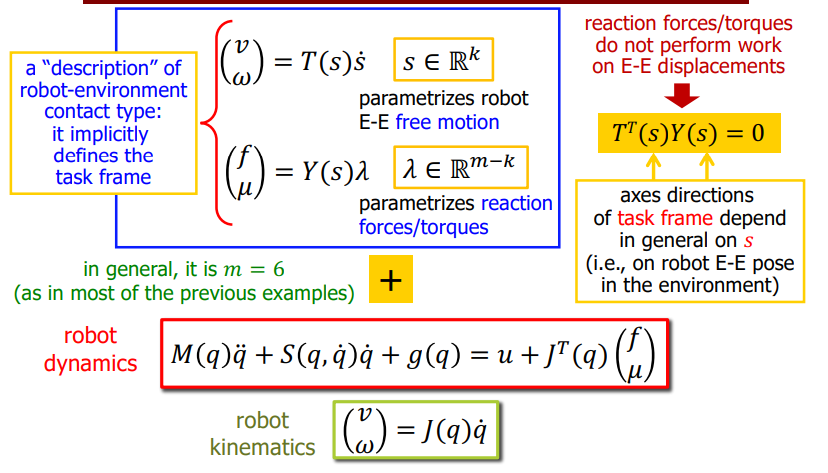


## Hybrid force/velocity control

The control objective is to impose desired task evolutions to the parameters s of motion  and to the parameters λ of force.

The control law is designed in two steps:
1. exact linearization and decoupling in the task frame by feedback

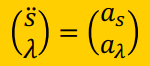

2. (linear) design of $a_s, a_λ$ so as to impose the desired dynamic behavior to the errors $e_s = s_d-s, e_λ= λ_d-λ$

The assumption here is n=m, and J(q) non-singular.


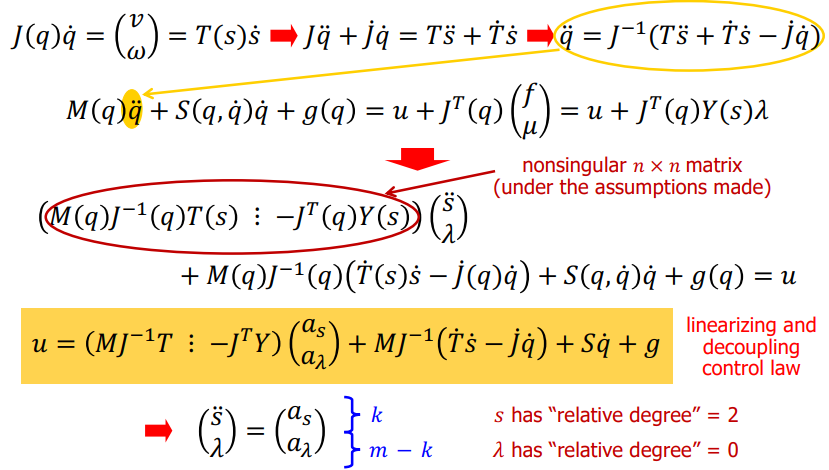

The stabilization with $a_s$ and $a_λ$ is anaylized by applying linear control techniques for the exponential stabilization of tracking errors on each joint.

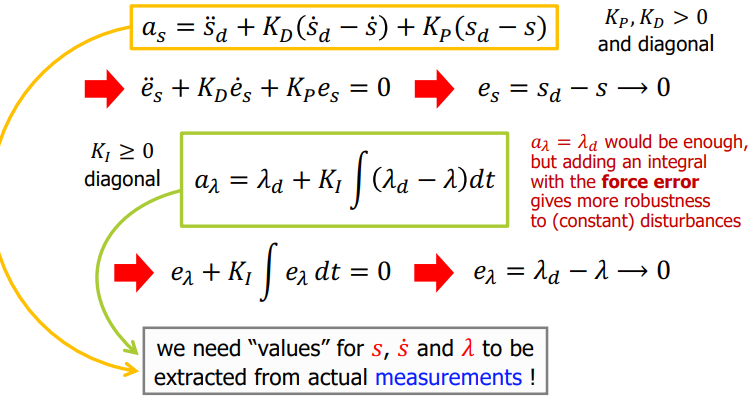

## Filtering position and force measures

$s$ and $ṡ$ are obtained from $q$ and $q̇$,  equating the descriptions
of the end-effector pose and velocity “from the robot side” (direct and
differential kinematics) and “from the environment side”.

$λ$ is obtained from force/torque measures at the end-effector.

## Block diagram of hybrid control

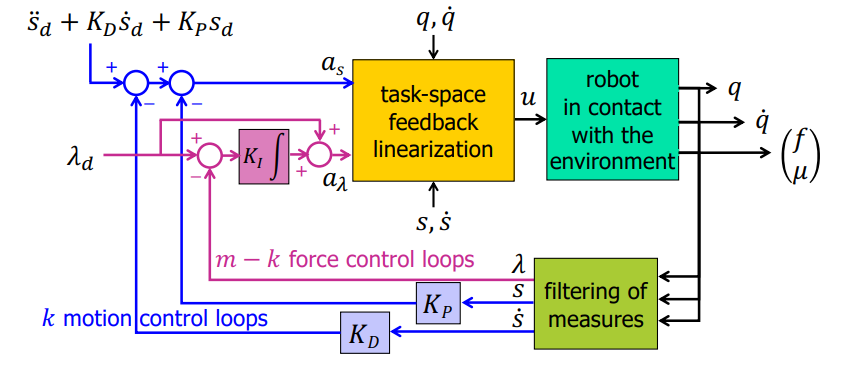


## Sources of inconsistency in force and velocity measurements

1. presence of friction at the contact
2. compliance in the robot structure and/or at the contact
3. uncertainty on environment geometry at the contact

## Estimation of an unknown surface

1. normal = nominal direction of measured force
2. tangent = nominal direction of measured velocity
3. mixed method (sensor fusion) with RLS


# Visual Servoing

The objective is to use information acquired by vision sensors (cameras) for feedback control of the pose/motion of a robot.

The positive aspect of data acquisition is that a very large information content are displayed in the acquired images.
However, it is difficult to extract essential data, there may be nonlinear perspective transformations, noise and difficult ambient conditions.

The image processing phase includes:
- real-time extraction of characteristic parameters useful for robot motion control
- low-level processing (binarization, equalization, edge detection, ...)
- segmentation
- interpretation

The vision system consists of some cameras, 3d stereo vision, camera positioning, robotized vision heads.

The visual servoing schemes are of different types:
- position-based visual servoing (PBVS)
- image-based visual servoing (IBVS)
- some mixed schemes

PBVS architecture

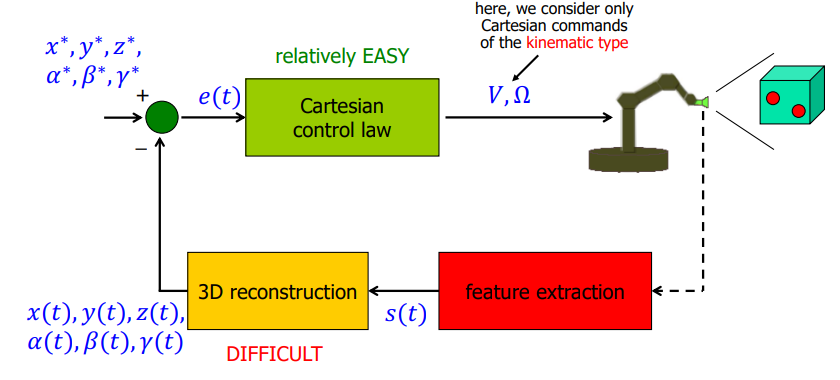

IBVS architecture

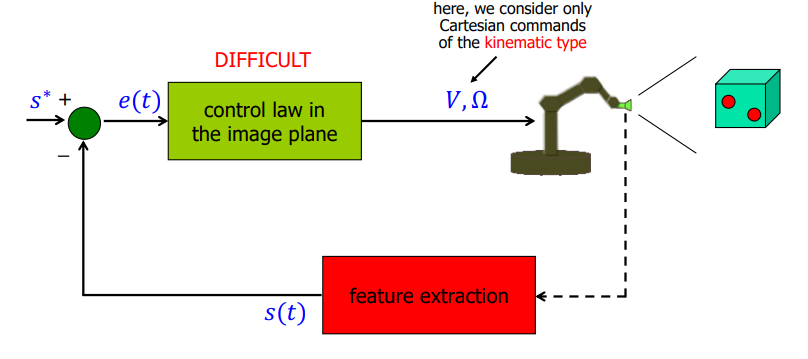

An IBVS scheme has the following steps:
- image acquisition
- feature extraction
- comparison with desired feature values
- generation of motion of the camera/robot


A feature is a characteristic or geometric structure that can be extracted from the image.
The numerical quantities associated to a feature are called feature parameters.

A camera model is made up of a set of lenses to focus the incoming light, a matrix containing the pixels values and the frame grabber.

A famous camera model is the pinhole camera model.

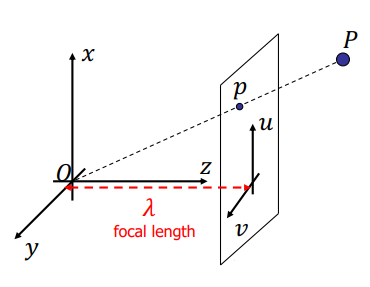

where $u=λ {X \over Z}$, $v=λ{Y \over Z}$.

The interaction matrix J(.) expresses the (kinematic) differential relation between motion imposed to the camera and motion of features on the image plane:

$ḟ = J(.) [V Ω]^T$,

$V, Ω ∈ R^6$ is the camera linear / angular velocity.
J(.) has dimension kx6.


## Robot differential kinematics

The case "eye-in-hand" is the one where the camera is mounted on the ee of a manipulator arm.

The motion (V, Ω) to to be imposed to the camera coincides with the
desired end-effector linear/angular velocity and is realized by
choosing the manipulator joint velocity (or, more in general, the
feasible velocity commands of a mobile manipulator)
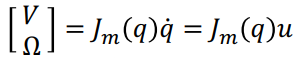

where $J_m$ is the geometric jacobian of the manipulator (or the NMM Jacobian of a mobile manipulator).

The image jacobian is the matrix $J(f,Z,q)$ which comes from the combination of $J_p$ and $J_m$:

$ḟ = J_p(f,Z)J_m(q)u = J(f,Z,q) u$

In practical cases one can only compute an approximation of the Image Jacobian because of the uncertainty in a number of relevant data (such as the depth of feature points). So the real case is that $JĴ^\# \neq I$, the error is then $ė=-JĴ^\#K e$ which converge locally if
$JĴ^\# > 0$.

In order to estimate online Z, the depth, we can use an observer, which has the following block diagram:

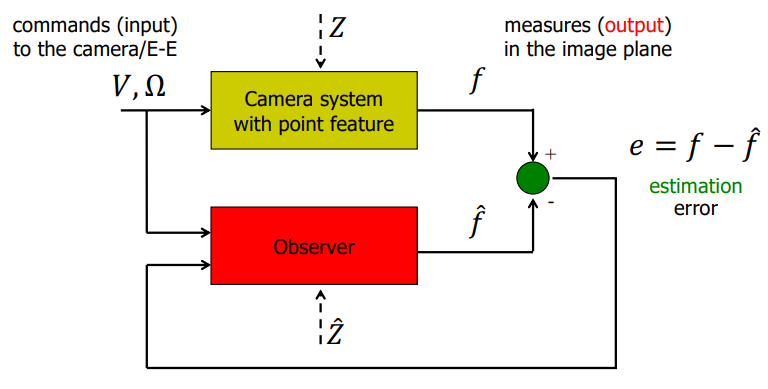

## Kinematic control for IBVS

We first define the error $e=f_d-f$.
Then we build the controller:

$u = J^\# (ḟ_d + ke)+(I-J^\#J)u_0$

This general choice will exponentially stabilize the task error to zero (up to singularities,
limit joint range/field of view, features exiting the image plane, ...)
In the redundant case, vector $u_0$ can be used for optimizing behavior/criteria.
The error feedback signal depends only on feature values, there is still a dependence of J on the depths Z of the features

### IBVS control with Task Sequencing

The approach is to regulate only one feature at the time, while keeping "fixed" the others by unobservable motions in the image plane.


### IBVS control with observer

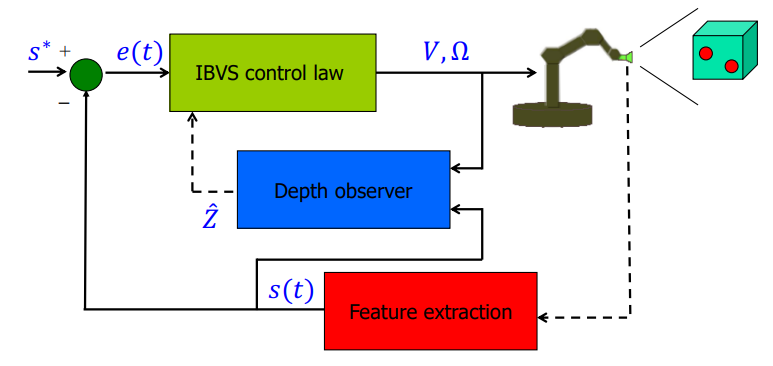


# Actuation Faults

In the diagnosis of faults possibly affecting a (nonlinear)
dynamic system various problems can be formulated
- Fault Detection
  - recognize that the malfunctioning of the (controlled) system is due
  to the occurrence of a fault (or not proper behavior) affecting some
  physical or functional component of the system
- Fault Isolation
  - discriminate which particular fault f has occurred out of a (large)
  class of potential ones, by distinguishing it from any other fault and
  from the effects of disturbances possibly acting on the system
- Fault Identification
  - determine the time profile (and/or class type) of the isolated fault f
- Fault Accommodation
  - modify the control law so as to compensate for the effects of the
  detected and isolated fault (possibly also identified)

- FDI solution (simultaneous detection and isolation)
  - definition of an auxiliary dynamic system (Residual Generator)
  whose output will depend only on the presence of the fault � to be
  detected and isolated (and not on any other fault or disturbance)
  and will converge asymptotically to zero when f ≡ 0 (stability)
  - in case of many potential faults, each component ri of the vector r
  of residuals will depend on one and only one associated fault fi
  (possibly reproducing approximately its time behavior)
  - many of the FDI schemes are model-based: they use a nominal
  (fault- and disturbance-free) dynamic model of the system
- Fault Tolerant Control
  - passive: control scheme that is intrinsically robust to uncertainties
  and/or faults (typically having only moderate/limited effects)
  - active: control scheme involving a reconfiguration after FDI (with
  guaranteed performance for the faulted system)

## FDI architecture

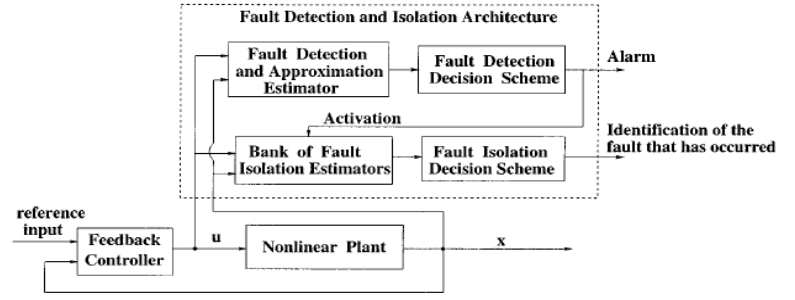


There is a bank of n + 1 (model-based) estimators: 1 for detection of a faulty condition, n for isolation of the specific (in general, modeled) fault.

## Actuator faults in robots

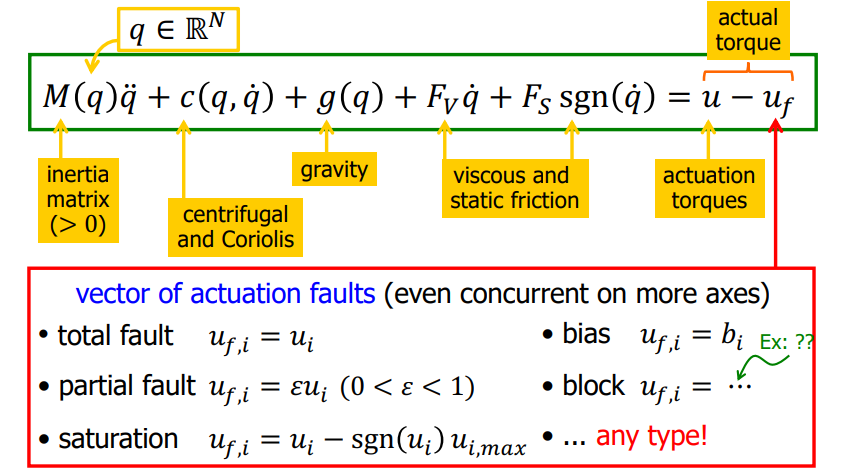

The assumptions we make are:
- signals and measurements available
- the robot dynamic model is known
- no dependence on/request of a specific input u(t)
- no dependence on/request of a specific motion $q_d(t)$



## Generalized momentum

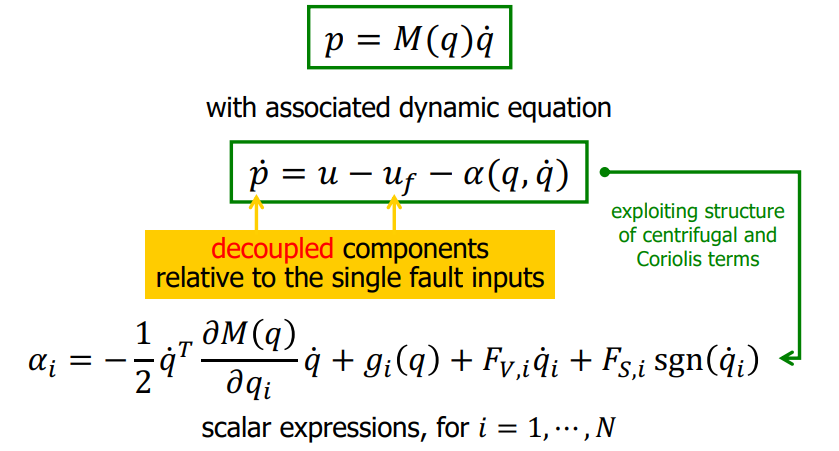


The FDI solution is the following:

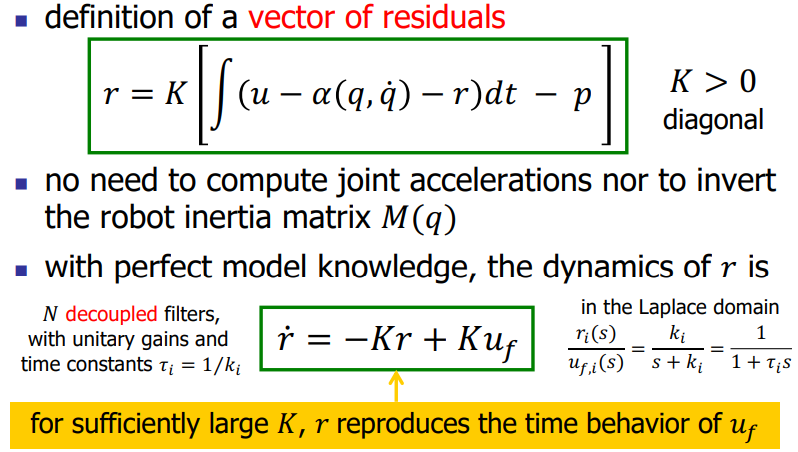

## Block diagram of the residual generator

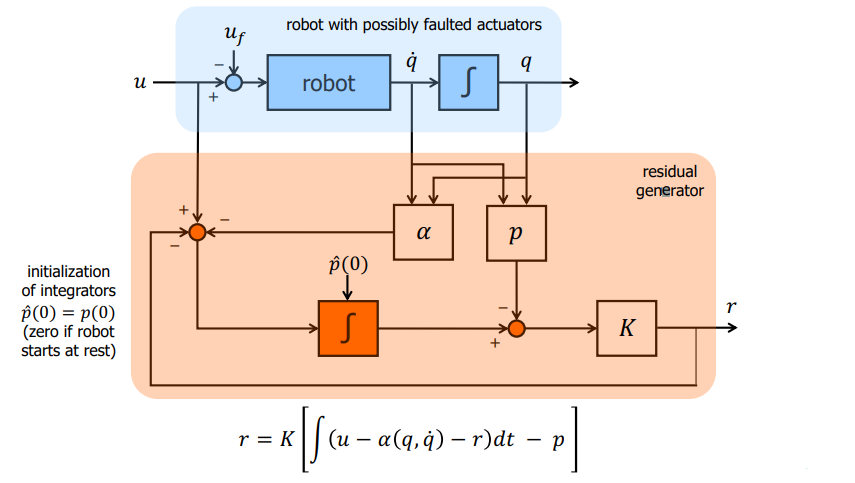

### Residual generator as "disturbance observer"

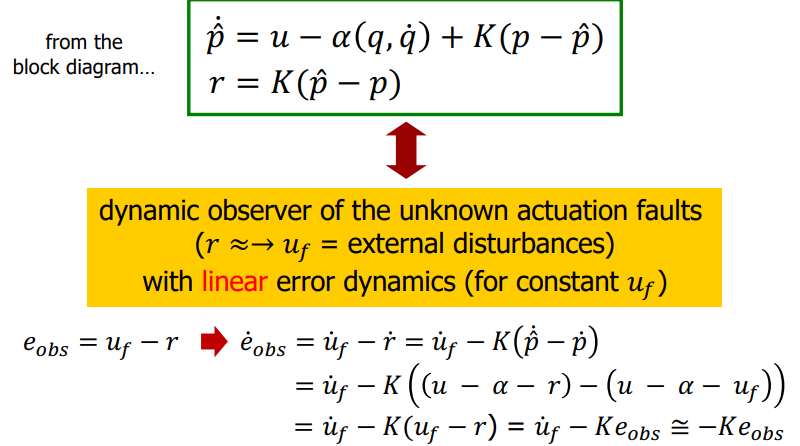